In [2]:
import os
import geopandas as gp
import shapely
import fiona
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

In [3]:
#Setting plot size
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [4]:
#Loading NSW map data
shp_file_name = "nsw_localities.shp"
zip_file_name = "nsw_locality_polygon_shp.zip"
web_file_path = (
    "https://data.gov.au/data/dataset/91e70237-d9d1-4719-a82f-e71b811154c6/resource/89af4ef8-7d45-4535-be38-221025695900/download/nsw_loc_gda2020.zip"
)

def unzip_zipfile(zipped_file_path, put_it_here="."):
    import zipfile
    zip_of_suburbs = zipfile.ZipFile(zipped_file_path, 'r')
    zip_of_suburbs.extractall(put_it_here)
    zip_of_suburbs.close()

if os.path.isfile(shp_file_name):
    print("loading from file")
else:
    if os.path.isfile(zip_file_name):
        print("unzipping")
        unzip_zipfile(zip_file_name)
    else:
        import requests
        print("loading from the internet")
        page = requests.get(web_file_path)
        with open(zip_file_name, 'wb') as z:
            z.write(page.content)
        unzip_zipfile(zip_file_name)

print("done")

burbs = gp.GeoDataFrame.from_file(shp_file_name)
burbs.set_crs(epsg=5234, inplace=True, allow_override=True) 
burbs.sample(2)


loading from file
done


,LC_PLY_PID,LOC_PID,DT_CREATE,LOC_NAME,LOC_CLASS,STATE,geometry
2501,lcp3Cx3KYqYMOdM,loc14dbe8c05101,2022-12-14,Maitland,Gazetted Locality,NSW,"POLYGON ((151.547 -32.719, 151.546 -32.720, 15..."
4104,lcpOkukP5Rypp46,loc51a1cfdcf2cd,2022-12-14,Upper Kangaroo River,Gazetted Locality,NSW,"POLYGON ((150.603 -34.667, 150.602 -34.668, 15..."


In [5]:
#Loading Airbnb listing data
if os.path.isfile("listings.csv"):
    filepath = "listings.csv"
    print("loading from file")
else:
    filepath = ""
    print("loading from the internet")

listing_data = pd.read_csv(filepath)
print("done")

loading from file
done


In [6]:
def add_centroid(row):
    return row.geometry.centroid

burbs["centroid"] = burbs.apply(add_centroid, axis=1)

Text(0.5, 1.0, 'Sydney Area')

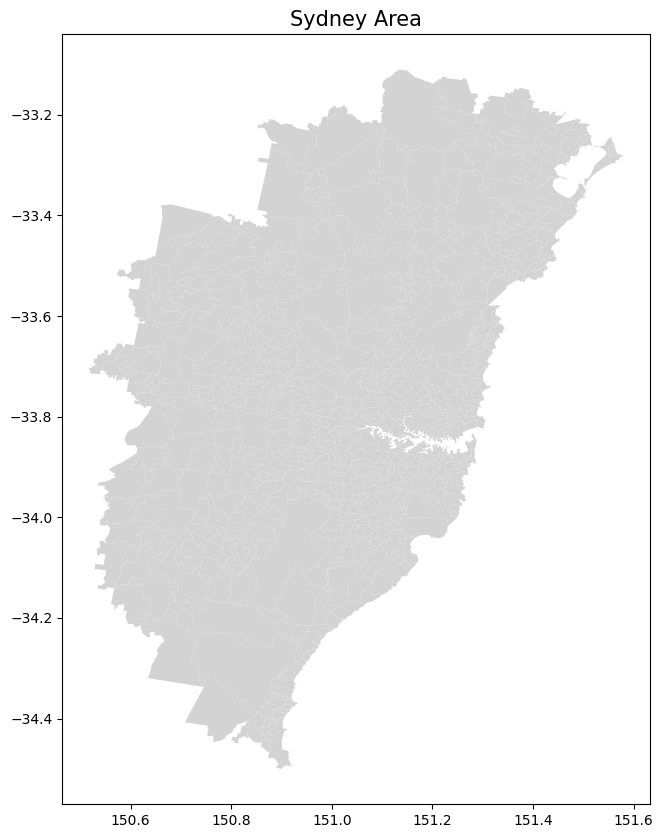

In [7]:
#Defining point on Opera House
right_here = shapely.geometry.point.Point(151.215135, -33.857062)
burbs["distance_from_opera_house"] = burbs.centroid.distance(right_here)

sydney_area = burbs[burbs.distance_from_opera_house < 0.7]
sydney_area.plot(color = 'lightgrey')

plt.title("Sydney Area", fontsize=15)



In [8]:
#What this does is it takes the listing CSV which we have, goes in there takes the Latitude and Longitude values, and it creates a new column called Geometry which is what Geopandas can interpret as a point on the map. The power of this is it did it automatically for all 20000+ rows
listing_data_geo = gp.GeoDataFrame(listing_data, geometry = gp.points_from_xy(listing_data.longitude,listing_data.latitude))

Text(0.5, 1.0, 'Sydney Area With Airbnb Listings')

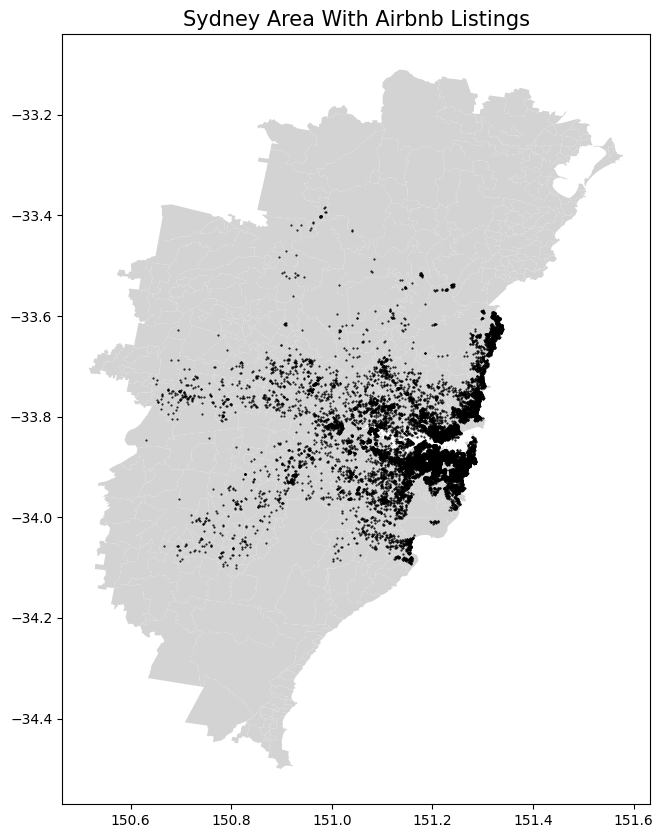

In [9]:
#Plotting the Sydney map
axis = sydney_area.plot(
    color = 'lightgrey', #edgecolor = 'white'
)

#Plotting the points of Airbnb listings
listing_data_geo.plot(ax = axis, color = 'black', markersize=0.25)

plt.title("Sydney Area With Airbnb Listings", fontsize=15)



In [10]:
#Setting the CRS on listing_data_geo
listing_data_geo.set_crs(epsg=5234, inplace=True, allow_override=True)

listing_data_geo.sample(1)

,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,geometry
5133,16417192,https://www.airbnb.com/rooms/16417192,20230606052803,2023-06-06,previous scrape,Rental unit in Northmead · 1 bedroom · 2 beds ...,My place is close to Lake Parramatta Reserve. ...,NaN,https://a0.muscache.com/pictures/563171ea-be9e...,107583812,...,NaN,NaN,NaN,f,1,0,1,0,NaN,POINT (150.996 -33.793)


In [11]:
#This operation took a long time to find and wrap my head around it, but to my knowledge what this does it take listing_data_geo(Airbnb listings with specified points) and sydney_area(map of Sydney) and it joins them based on their location, which is specified to be within, hence the name SpacialJoin aka. sjoin
states_with_listings = gp.sjoin(listing_data_geo, sydney_area, how='inner', predicate='within')

In [12]:
#There are Airbnb listings in 582 different suburbs in Sydney out of the 658 (infromation from the internet)
states_with_listings.value_counts("LOC_NAME")

LOC_NAME
Bondi Beach            1082
Manly                   773
Surry Hills             693
Bondi                   556
Sydney                  509
                       ... 
Bankstown Aerodrome       1
Yarrawarrah               1
Audley                    1
Agnes Banks               1
Abbotsbury                1
Name: count, Length: 582, dtype: int64

In [13]:
#There are a total of 23441 listings in Sydney
states_with_listings.LOC_NAME.count()

23441

Text(0, 0.5, 'Airbnb Listings')

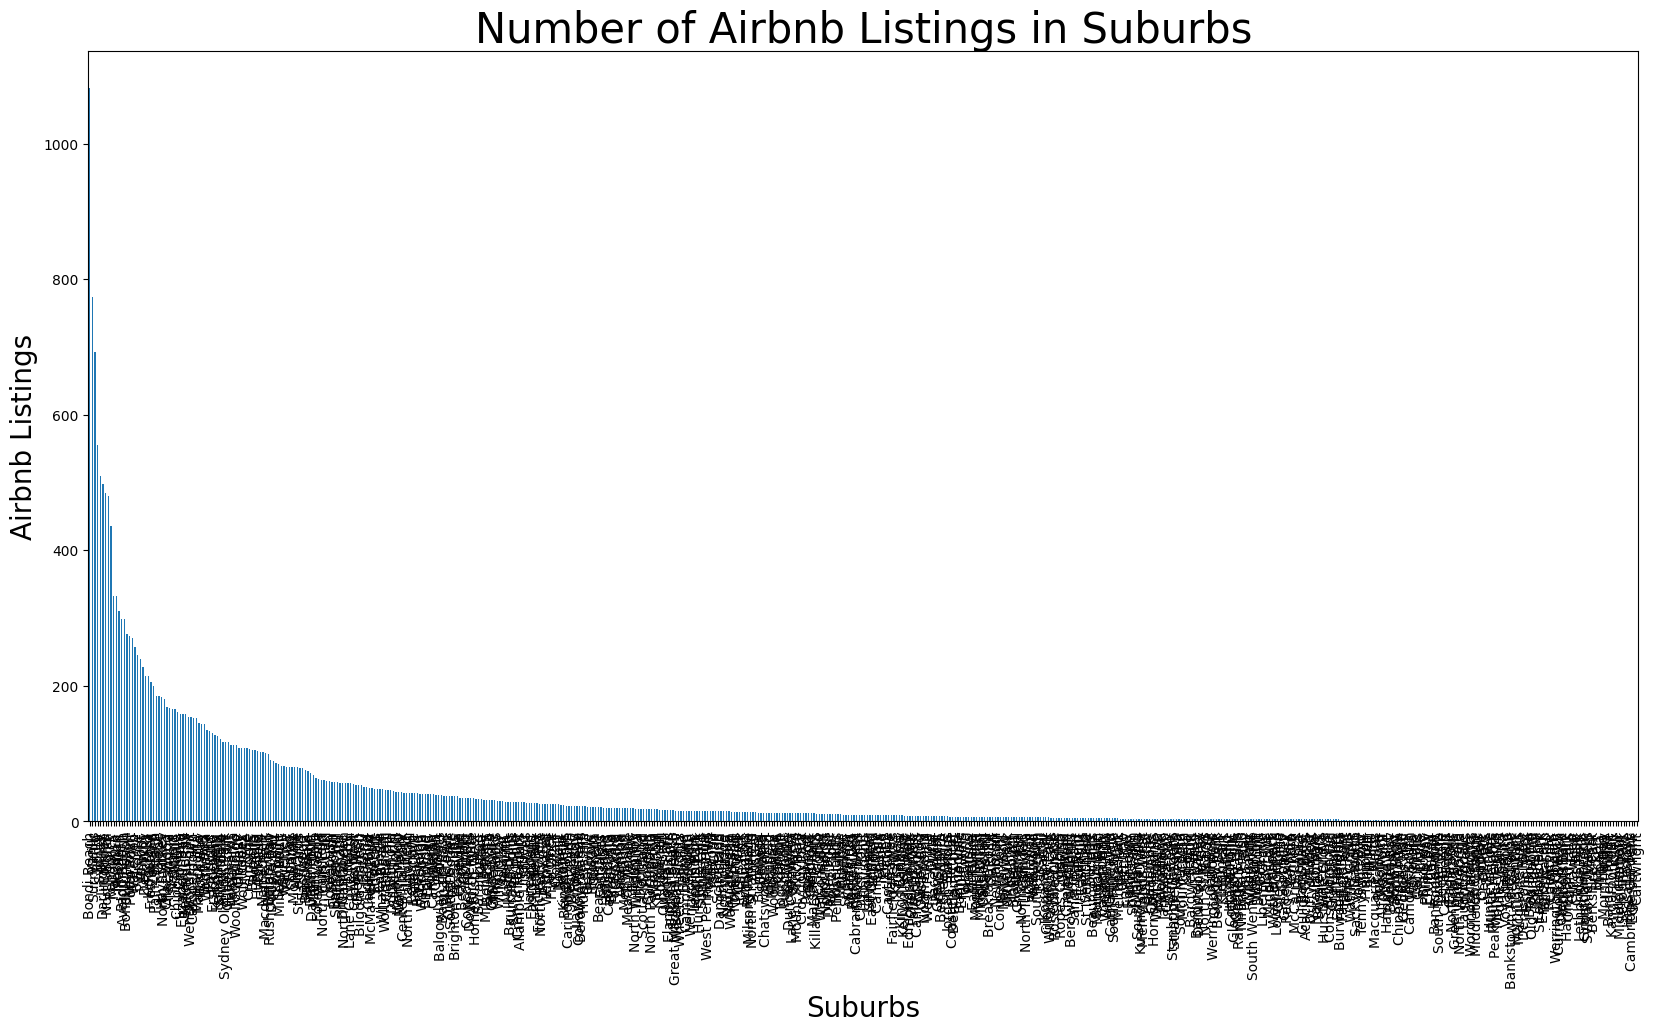

In [14]:
states_with_listings.LOC_NAME.value_counts().plot(kind="bar")

plt.title("Number of Airbnb Listings in Suburbs", fontsize=30)
plt.xlabel("Suburbs", fontsize=20)
plt.ylabel("Airbnb Listings", fontsize=20)

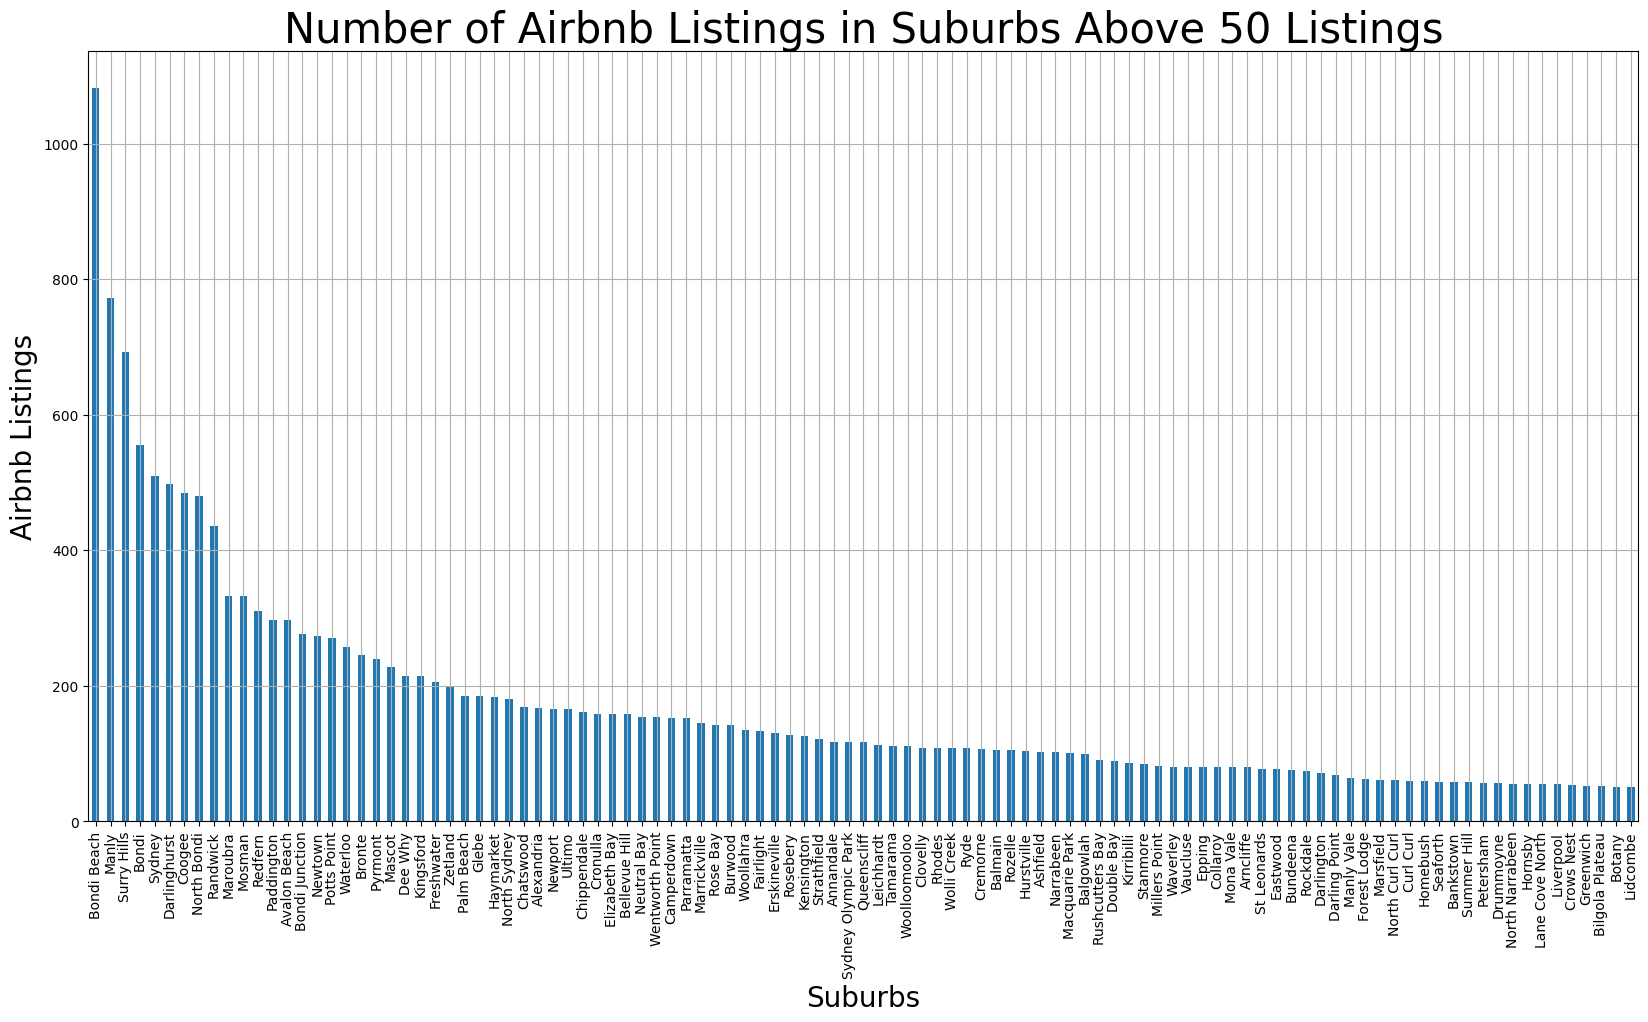

In [15]:
states_with_listings.LOC_NAME.value_counts()[states_with_listings.LOC_NAME.value_counts() > 50].plot(kind="bar")

plt.title("Number of Airbnb Listings in Suburbs Above 50 Listings", fontsize=30)
plt.xlabel("Suburbs", fontsize=20)
plt.ylabel("Airbnb Listings", fontsize=20)
plt.grid(True)

Text(0, 0.5, 'Airbnb Listings')

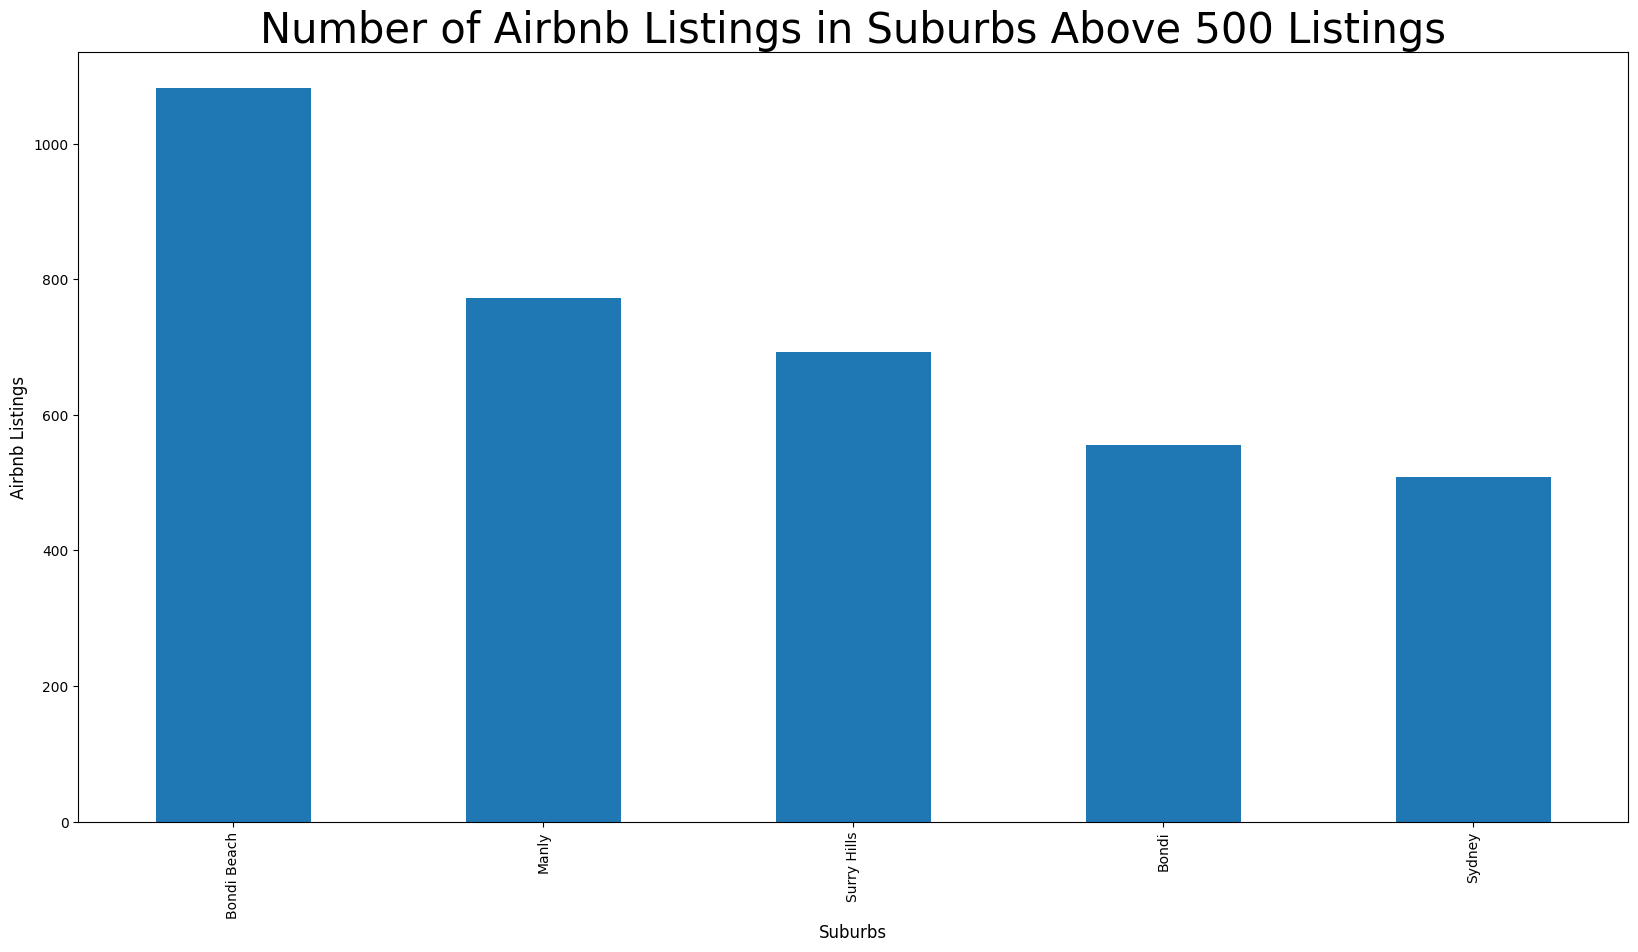

In [16]:
states_with_listings.LOC_NAME.value_counts()[states_with_listings.LOC_NAME.value_counts() > 500].plot(kind="bar")

plt.title("Number of Airbnb Listings in Suburbs Above 500 Listings", fontsize=30)
plt.xlabel("Suburbs", fontsize=12)
plt.ylabel("Airbnb Listings", fontsize=12)


Text(0.5, 1.0, 'Airbnb Locations in Bondi Beach')

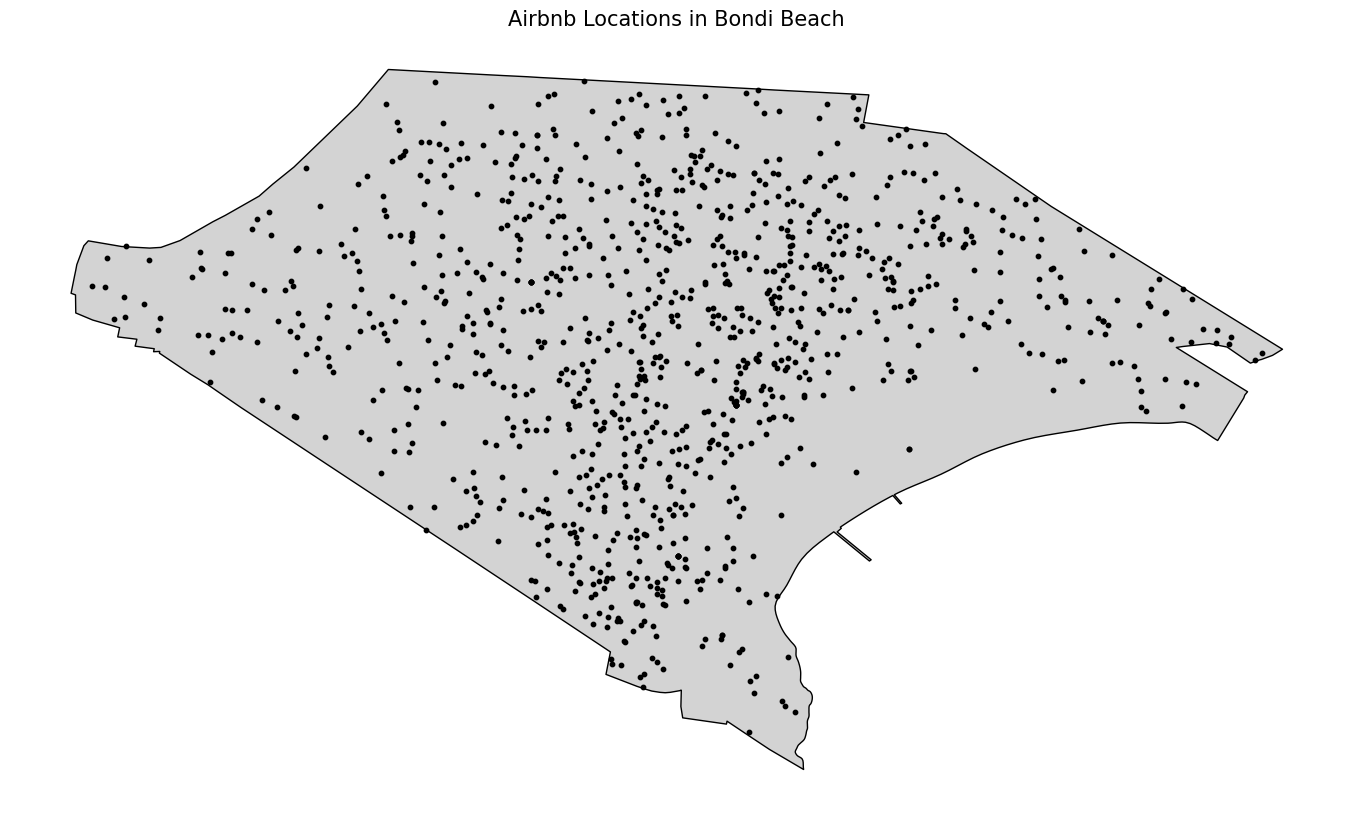

In [17]:
axis = burbs[burbs.LOC_NAME == "Bondi Beach"].plot(color = 'lightgrey',  edgecolor = 'black')

states_with_listings[states_with_listings.LOC_NAME == 'Bondi Beach'].plot(ax = axis, color = 'black', markersize=10)

axis.set_axis_off()

plt.title("Airbnb Locations in Bondi Beach", fontsize=15)

In [18]:
#Defineds what listing_count is, and adds a new column to states_with_listings, which includes Listing_Count
listing_count = states_with_listings["LOC_NAME"].value_counts()

states_with_listings["Listing_Count"] = states_with_listings["LOC_NAME"].map(listing_count)

In [19]:
#I don't really understand how this works, but it gives me an accurate choropleth map. I tried so many different operations to merge the Listing_Count with sydney_area(map of Sydeny), and I tried this to see if it would work, and it does, not in the prettiest way, there is probably a way which I don't know about that would be easier, and prettier, and more useful, but I can not find any.
listing_count_suburbs = sydney_area.join(states_with_listings.set_index("LOC_NAME"), on='LOC_NAME', how='inner', rsuffix="LOC_NAME" )


In [ ]:
listing_count_suburbs.plot(column="Listing_Count", cmap='plasma', legend=True, legend_kwds={"label": "Airbnb Listing Amount"})

plt.title("Sydney Area With Airbnb Listings", fontsize=15)


: 

: 

In [ ]:
axis = burbs[burbs.LOC_NAME == "Bondi Beach"].plot(color = 'lightgrey',  edgecolor = 'black')

states_with_listings[states_with_listings.LOC_NAME == 'Bondi Beach'].plot(column="review_scores_rating", ax = axis, markersize=20, cmap='plasma', legend=True, legend_kwds={"label": "Ratings"})

axis.set_axis_off()

plt.title("Airbnb Locations in Bondi Beach Colored Based on Review Scores Ratings", fontsize=15)

In [ ]:
axis = burbs[burbs.LOC_NAME == "Bondi Beach"].plot(color = 'lightgrey',  edgecolor = 'black')

states_with_listings[states_with_listings.LOC_NAME == 'Bondi Beach'].plot(column="review_scores_value", ax = axis, markersize=20, cmap='plasma', legend=True, legend_kwds={"label": "Ratings"})

axis.set_axis_off()

plt.title("Airbnb Locations in Bondi Beach Colored Based on Review Socre Value", fontsize=15)

In [ ]:
axis = burbs[burbs.LOC_NAME == "Bondi Beach"].plot(color = 'lightgrey',  edgecolor = 'black')

states_with_listings[states_with_listings.LOC_NAME == 'Bondi Beach'].plot(column="review_scores_location", ax = axis, markersize=20, cmap='plasma', legend=True, legend_kwds={"label": "Ratings"})

axis.set_axis_off()

plt.title("Airbnb Locations in Bondi Beach Colored Based on Location Ratings", fontsize=15)